# Simple Gaussian Process Regression

Gaussian Processes (GPs) are Bayesian probablistic models that are frequently applied to regression and classification problems. As the name would suggest, Bayesian methods are based on Bayes' theorem, which given a model with parameters $\boldsymbol{\theta}$, and observed data $\mathbf{X}$, is written as 


\begin{equation}
p(\boldsymbol{\theta}|\mathbf{X}) = \frac{p(\mathbf{X}|\boldsymbol{\theta})p(\boldsymbol{\theta})}{p(\mathbf{X})} \tag{1}
\end{equation}

The quantity $p(\mathbf{X}|\boldsymbol{\theta})$ is known as the likelihood and expresses the probability of the observed data for the specific value of $\boldsymbol{\theta}$. Different values of $\boldsymbol{\theta}$ will produce different likelihoods,
indicating which parameter choices appear to best describe the observed data. The distribution $p(\boldsymbol{\theta})$ is known as the prior over $\boldsymbol{\theta}$, and contains all our assumptions and beliefs about $\boldsymbol{\theta}$ before any observations of the data have occurred. The denominator is known as the marginal likelihood, or the evidence. It acts as a normalising constant that ensures the RHS of Bayes' theorem integrates to one, as a probability density must. The conditional probability $p(\boldsymbol{\theta}|\mathbf{X})$ is the posterior distribution of $\boldsymbol{\theta}$ after combining our prior intuition with the current data observations and normalising by the overall evidence. The posterior is a compromise between the prior and the likelihood, with the exact combination influenced by the properties of the prior and the quality of the data used to compute the likelihood.

Once the posterior distribution over the parameters has been calcuated, we can make predictions for the unobserved test point $\mathbf{x}_*$ by calculating the posterior predicitive distribution. This is obtained by integrating over all the parameters in the parameter space $\boldsymbol{\Theta}$ (marginalising out the parameters):

\begin{equation}
p(\mathbf{x}_*|\mathbf{X})=\int_{\Theta}p(\mathbf{x}_*|\boldsymbol{\theta})p(\boldsymbol{\theta}|\mathbf{X})\:d\boldsymbol{\theta} \tag{2}
\end{equation}

In GP regression we don't need to explicitly compute equations (1) and (2); we can simply use the properties of multivariate Gaussians to obtain the predictive distribution.

## Gaussian Process Regression

A GP is defined as a stochastic process (a collection of random variables indexed by some mathematical set) such that any finite collection of the random variables has a joint Gaussian distribution. Therefore, a GP can be thought of as the generalisation of the multivariate Gaussian to infinite dimensions; theoretically, if we were to sample from a GP we would obtain an infinite-dimensional vector.

For the input $\mathbf{x}$, the GP is written as

\begin{equation}
f(\mathbf{x})\sim \mathcal{GP}(m(\mathbf{x}),k(\mathbf{x},\mathbf{x'}))\tag{3}
\end{equation} 

where the mean function $m(\mathbf{x})$, and the covariance (or kernel) function $k(\mathbf{x},\mathbf{x'})$ are given by

\begin{equation}
m(\mathbf{x})=\mathbb{E}[f(\mathbf{x})]\tag{4}
\end{equation}
\begin{equation}
k(\mathbf{x},\mathbf{x'})=\mathbb{E}[(f({\mathbf{x}})-m(\mathbf{x}))(f({\mathbf{x'}})-m(\mathbf{x'}))]\tag{5}
\end{equation}

As mentioned above, for any finite set of points $\mathbf{X}=\{\mathbf{x}_1,\mathbf{x}_2,...,\mathbf{x}_n\}$, the GP defines the multivariate Gaussian distribution on the associated function values $\mathbf{f}=f(\mathbf{X})$:

\begin{equation}
p(\mathbf{f}|\mathbf{X})=\mathcal{N}(\mathbf{f}|\boldsymbol{\mu},\mathbf{K})\tag{6}
\end{equation}

We begin by importing some libraries and functions we are going to use.

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
from scipy.stats import norm
from scipy.linalg import det
from scipy.optimize import minimize

In this problem we are going to attempt to model a function from a small number of noise-free observations. Before we observe any data we will generate a GP prior over the function values. The GP prior should factor in any previous knowledge and assumptions we have about the problem at hand, and generate functions that demonstrate suitable properties for modelling our unseen data. In practice this means selecting an appropriate covariance (and possibly a mean) function and some reasonable values for its parameters.

For example, say we understand the physical process that produces the observations and know that the produced data will be very smooth. Or say that we have conducted the experiment many times before and have seen that the data is smooth. In this case we can use the Radial Basis Function (RBF) as our covariance function, since it generates very smooth functions.

For the inputs $\mathbf{x}$ and $\mathbf{x}'$, the RBF kernel is defined as

\begin{equation}
k(\mathbf{x},\mathbf{x}')_{RBF}=\alpha^2\exp\biggl(-\frac{|\mathbf{x}-\mathbf{x}'|^2}{2l^2}\biggr)\tag{7}
\end{equation}

where $l$ is known as the characteristic length scale and $\alpha$ as the amplitude parameter.

Below we plot five sample functions drawn from a GP prior. Using some prior knowledge of our problem, we have chosen to use the RBF as the covariance function and set $\alpha=1$ and $l=2$,

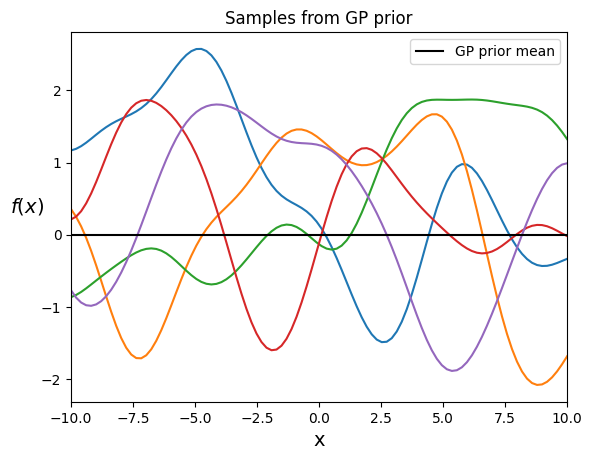

In [16]:
def RBF_cov(x, y, params):
    
    """
    Calculates the RBF covariance matrix for inputs x and y.
    """
    # generate empty matrix
    cov_matrix = np.zeros((len(x),len(y)))
    # compute the value of each element
    for i in range(len(x)):
        for j in range(len(y)):
            rbf = np.exp(-(x[i]**2 + y[j]**2 - 2*x[i]*y[j])/(2*params[1]**2))
            cov_matrix[i,j] = rbf
    
    return params[0]**2*cov_matrix 

# input points over which the GP prior will be sampled for the plot
xs = np.linspace(-10,10,100)
# calculate the RBF covariance matrix for the input
k = RBF_cov(xs, xs, [1,2])
# generate sample "functions"
samples = np.random.multivariate_normal(mean=np.zeros(len(xs)), cov=k, size=5)
# generate zero mean for plot
prior_mean = np.zeros(len(xs))

# plot samples form GP prior
fig=plt.figure()
ax = fig.add_subplot()
ax.plot(xs, samples.T)
ax.plot(xs, prior_mean, c='k', label='GP prior mean')
ax.set_xlim(-10,10)
ax.set_xlabel("x", fontsize=14)
ax.set_ylabel(r"$f(x)$", fontsize=14, rotation=0, labelpad=10)
ax.set_title("Samples from GP prior")
ax.legend()
plt.show()

We have chosen the GP prior to have a mean of zero. The five sample functions shown do not have zero mean, but if all the infinitely-many possible functions were shown, this would be the case.

It isn't practically feasible to work with infinite-dimensional objects, so we sample the funtions over a finite set of input (or index) points in accordance with equation (6). In the above case, the functions have been sampled over 100 evenly-spaced input points on the interval $[-10,10]$. This means we are actually plotting samples from a 100-dimensional multivariate Gaussian distribtution.

Now let's create three noise-free training observations from a function and plot them.

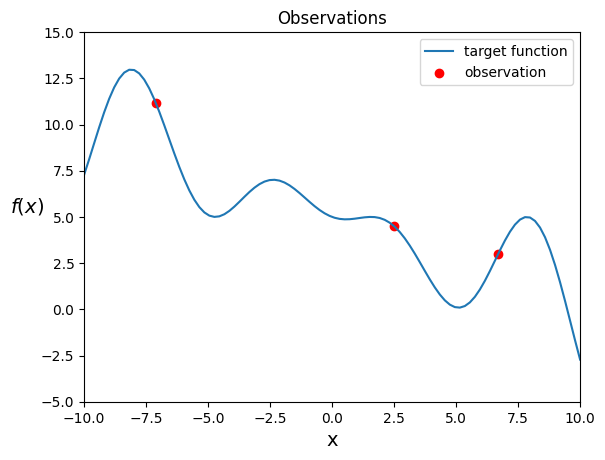

In [17]:
def function(x):
    
    """
    Defines a function which will act as our target (the values we want to predict).
    """
    
    f = 0.5*x*np.sin(x)-0.5*x + 5
    
    return f

# generate training and test data
X_train = np.array([-7.1, 2.5, 6.7])
y_train = function(X_train)
X_test = np.linspace(-10,10,100)

# plot target function and our three observations
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(xs, function(xs), label="target function")
ax.scatter(X_train, y_train, c="r", label="observation")
ax.set_xlim(-10,10)
ax.set_ylim(-5,15)
ax.set_xlabel("x", fontsize=14)
ax.set_ylabel(r"$f(x)$", fontsize=14, rotation=0, labelpad=10)
ax.set_title("Observations")
plt.legend()
plt.show()

Next we will use a GP model to make predictions for new test points.

In the GP formalism, apart from learning the covariance function parameters, no training is required; we are able to write down the exact equations that we will use to make predictions for the test points. Utilising the properties of multivariate Gaussians, marginalisation is performed on the infinite-dimensional GP prior to yield the joint Gaussian distribution between $\mathbf{f}_*$, the function values for the test set $\mathbf{X}_*$ of size $N_*$, and $\mathbf{f}$, the function values for the $N$ noise-free training observations $\mathbf{X}$:

\begin{equation}
\begin{bmatrix}
\mathbf{f}\\
\mathbf{f_*}
\end{bmatrix}\sim \mathcal{N}\left(\begin{bmatrix}
\boldsymbol{\mu}\\
\boldsymbol{\mu}_*
\end{bmatrix}, \begin{bmatrix}
K(\mathbf{X},\mathbf{X}) & K(\mathbf{X},\mathbf{X}_*)\\
K(\mathbf{X}_*,\mathbf{X}) & K(\mathbf{X}_*,\mathbf{X}_*)
\end{bmatrix}\right) \tag{8}
\end{equation}

where $K(\mathbf{X},\mathbf{X})$ is an $N\times N$ matrix of the covariance function evaluated for all possible pairs of training points, $K(\mathbf{X},\mathbf{X}_*)$ is an $N\times N_*$ matrix of the covariance function evaluated for all possible pairs of training and test points, and similarly for the matrices $K(\mathbf{X}_*,\mathbf{X})$ and $K(\mathbf{X}_*,\mathbf{X}_*)$.

Employing the rules of Gaussian conditioning, the posterior predictive distribution of $\mathbf{f}_*$ is obtained as

\begin{align}
p(\mathbf{f}_*|\mathbf{X}_*,\mathbf{X},\mathbf{f})&=\mathcal{N}(\boldsymbol{\mu}_{\mathbf{f}_*|\mathbf{f}},\mathbf{\Sigma}_{\mathbf{f}_*|\mathbf{f}})\tag{9}\\
\boldsymbol{\mu}_{\mathbf{f}_*|\mathbf{f}}&=\boldsymbol{\mu}_*+K(\mathbf{X}_*,\mathbf{X})K(\mathbf{X},\mathbf{X})^{-1}(\mathbf{f}-\boldsymbol{\mu})\tag{10}\\\boldsymbol{\Sigma}_{\mathbf{f}_*|\mathbf{f}}&=K(\mathbf{X}_*,\mathbf{X}_*)-K(\mathbf{X}_*,\mathbf{X})K(\mathbf{X},\mathbf{X})^{-1}K(\mathbf{X},\mathbf{X}_*)\tag{11}
\end{align}

To make predictions from $p(\mathbf{f}_*|\mathbf{X}_*,\mathbf{X},\mathbf{f})$, we can either sample from the distribution, or simply use the mean $\boldsymbol{\mu}_{\mathbf{f}_*|\mathbf{f}}$ as the prediction, i.e., we marginalise the distribution on each test point to extract the mean and standard deviation.

A key feature of GP regression is that although GPs are defined in an infinite-dimensional space, to make predictions we only need to know the Gaussian distribution of a finite set of the possible inputs (the training and test points).

For simplicity we are going to assume a zero-mean GP prior. Therefore, we should take the mean of our training observations and subtract it from the observations so that they also have a mean of zero. After computing the GP posterior we can then add the mean of the observations to make predictions.

Below we define a function to compute the GP posterior using equations (9) - (11). As a test set we use 100 equally-spaced points on the interval $[-10,10]$. This enables us to plot sample "functions" from the GP posterior and the predictive mean.

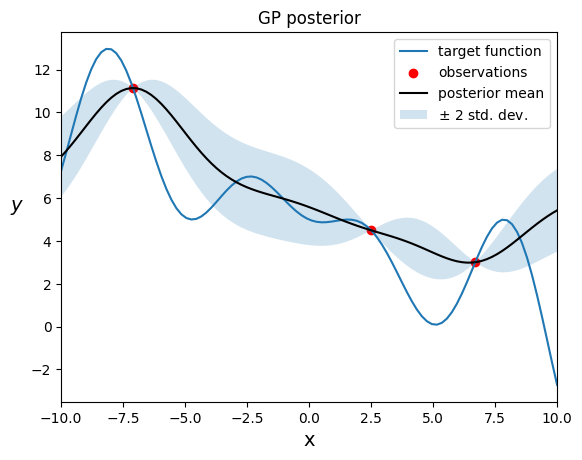

In [18]:
def GP_posterior(X_train, y_train, x_test, kernel_function, params, y_train_mean=0):
    
    """
    Computes the GP posterior predictive distribution in the case of noise-free data.
    """
    # ompute the covariance matrices in equation (8)
    K_train_train_y = kernel_function(X_train, X_train, params)
    K_train_test = kernel_function(X_train, X_test, params)
    K_test_train = kernel_function(X_test, X_train, params)
    K_test_test = kernel_function(X_test, X_test, params)
    # compute the inverse of the covariance matrix between the training points
    K_train_train_y_inv = inv(K_train_train_y)
    # equation (10)
    mean = np.dot(K_test_train, np.dot(K_train_train_y_inv, y_train-y_train_mean))
    # equation (11)
    cov = K_test_test - np.dot(K_test_train, np.dot(K_train_train_y_inv, K_train_test))
    
    return mean, cov 


def plot_GP_posterior(mean, cov, xs, X_train, y_train, X_test):
    
    """
    Plots the GP posterior predicitve distribution in the case of noise-free data.
    """
    # calculate the variances
    variances = np.diag(cov).copy()
    # ensure variances don't go below zero due to rounding errors
    variances[variances<0]=0
    # calculate the standard deviations
    std_devs = np.sqrt(variances)
    # plot the GP posterior
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(xs, function(xs), label="target function")
    ax.scatter(X_train, y_train, c="r", label="observations")
    ax.plot(X_test, mean, c='k', label="posterior mean")
    ax.fill_between(X_test, mean-2*std_devs, mean+2*std_devs, alpha=0.2, label=r"$\pm$ 2 std. dev.")
    ax.set_xlim(-10,10)
    ax.set_xlabel("x", fontsize=14)
    ax.set_ylabel(r"$y$", fontsize=14, rotation=0, labelpad=10)
    ax.set_title("GP posterior")
    plt.legend()
    plt.show()
    
# calculate the mean of the training observations (f(x)) to centre the data on zero
y_train_mean = np.mean(y_train)
# compute the predictive mean and covariance, and plot
mean, cov = GP_posterior(X_train, y_train, X_test, RBF_cov, [1, 2], y_train_mean)
plot_GP_posterior(mean+y_train_mean, cov, xs, X_train, y_train, X_test)

With only three observations the GP stuggles to model the underlying function that generated the observations.

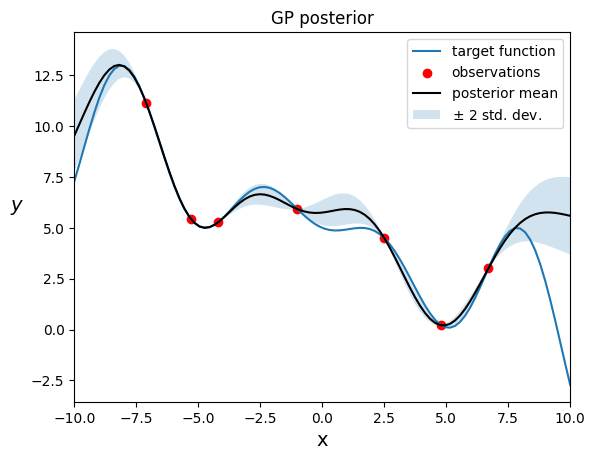

In [19]:
# add some more points to the previous training set
X_train_2 = np.array([-7.1, -5.3, -4.2, -1, 2.5, 4.8, 6.7])
y_train_2 = function(X_train_2)
# calculate the mean of the training observations (f(x)) to centre the data on zero
y_train_2_mean = np.mean(y_train_2)
# compute the predictive mean and covariance, and plot
mean2, cov2 = GP_posterior(X_train_2, y_train_2, X_test, RBF_cov, [1, 2], y_train_2_mean)
plot_GP_posterior(mean2+y_train_2_mean, cov2, xs, X_train_2, y_train_2, X_test)

With an additional four obserations the GP does a better job of modelling the target function, but the fit is still limited in some regions, particularly near the endpoints of the interval.

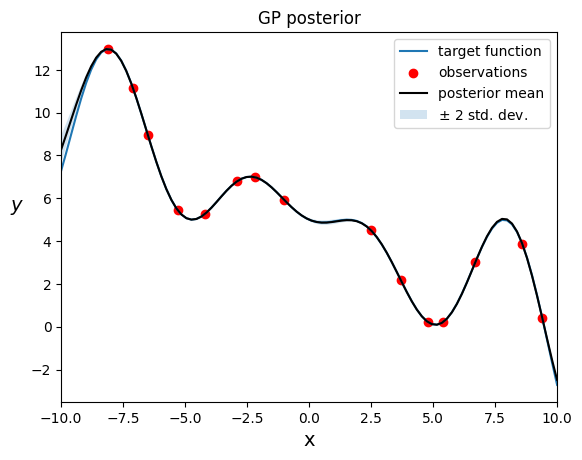

In [20]:
# add some points to the previous training set
X_train_3 = np.array([-8.1, -7.1, -6.5, -5.3, -4.2, -2.9, -2.2, -1, 2.5, 3.7, 4.8, 5.4, 6.7, 8.6, 9.4])
y_train_3 = function(X_train_3)
# calculate the mean of the training observations (f(x)) to centre the data on zero
y_train_3_mean = np.mean(y_train_3)
# compute the predictive mean and covariance, and plot
mean3, cov3 = GP_posterior(X_train_3, y_train_3, X_test, RBF_cov, [1, 2], y_train_3_mean)
plot_GP_posterior(mean3+y_train_3_mean, cov3, xs, X_train_3, y_train_3, X_test)

With an additional eight observations, the GP model performance is mostly very good.

## Noisy Data

To make things more interesting we can add some Gaussian noise to the observations, i.e., now we are trying to model the values $y=f(\mathbf{x})+\epsilon$, where $\epsilon\sim\mathcal{N}(0,\sigma_N^2)$, instead of $f(\mathbf{x})$.

Our approach and the equations we use for the predictive distribution remain mostly unchanged; the only differences now are that the matrix $K(\mathbf{X},\mathbf{X})$ is replaced by $\mathbf{K}_y=K(\mathbf{X},\mathbf{X})+\sigma_N^2\mathbf{I}$, and $\mathbf{f}$ by $\mathbf{y}$, to yield the posterior predictive distribution

\begin{align}
p(\mathbf{f}_*|\mathbf{X}_*,\mathbf{X},\mathbf{y})&=\mathcal{N}(\boldsymbol{\mu}_{\mathbf{f}_*|\mathbf{f}},\mathbf{\Sigma}_{\mathbf{f}_*|\mathbf{f}})\tag{12}\\
\boldsymbol{\mu}_{\mathbf{f}_*|\mathbf{f}}&=\boldsymbol{\mu}_*+K(\mathbf{X}_*,\mathbf{X})[K(\mathbf{X},\mathbf{X})+\sigma_N^2\mathbf{I}]^{-1}(\mathbf{y}-\boldsymbol{\mu})\tag{13}\\\boldsymbol{\Sigma}_{\mathbf{f}_*|\mathbf{f}}&=K(\mathbf{X}_*,\mathbf{X}_*)-K(\mathbf{X}_*,\mathbf{X})[K(\mathbf{X},\mathbf{X})+\sigma_N^2\mathbf{I}]^{-1}K(\mathbf{X},\mathbf{X}_*)\tag{14}
\end{align}

On this occasion, with a more complicated problem, we are going to train the model hyperparmeters (the parameters of the kernel function).

There are several possible ways to do this, but we will use the method of maximising the marginal likelihood. The marginal likelihood is the integral over the function values $\mathbf{f}$ of the product of the likelihood and the prior:

\begin{equation}
p(\mathbf{y}|\mathbf{X},\boldsymbol{\theta})=\int p(\mathbf{y}|\mathbf{f},\mathbf{X})p(\mathbf{f}|\mathbf{X},\boldsymbol{\theta})\:d\mathbf{f}\tag{15}
\end{equation}

where $\boldsymbol{\theta}$ is the vector of model hyperparameters. Different values of $\boldsymbol{\theta}$ will produce different marginal likelihoods, with the idea being that by maximising the marginal likelihood, we will find the hyperparameters that have the greatest probability of producing the observed data.

Primarily due to issues with numeric stability, it is preferred to work with the log marginal likelihood

\begin{equation}
\log p(\mathbf{y}|\mathbf{X},\boldsymbol{\theta})=-\frac{1}{2}(\mathbf{y}-\boldsymbol{\mu})^T\mathbf{K}_y^{-1}(\mathbf{y}-\boldsymbol{\mu})-\frac{1}{2}\log|\mathbf{K}_y|-\frac{N}{2}\log2\pi\tag{16}
\end{equation}

In the cell below we have a function that adds Gaussian noise to the original target function, and another for calculating the log marginal likelihood.

In [21]:
def noisy_function(x, std_dev):
    
    """
    Defines the target function from earlier but with added Gaussian noise, i.e., y = f(x) = ε.
    """
    
    noise = np.random.normal(scale=std_dev, size=len(x))
    f = 0.5*x*np.sin(x) - 0.5*x + 5 + noise
    
    return f   


def log_marginal_likelihood_noise(X_train, y_train, kernel_function, parameters, std_dev, y_train_mean=0):
    
    """
    Defines the log marginal likelihood as defined in equation (16).
    """
    
    K_train_train_y = kernel_function(X_train, X_train, parameters) + std_dev**2*np.eye(len(X_train))
    K_train_train_y_inv = inv(K_train_train_y)
    lml = -0.5*np.dot((y_train-y_train_mean).T, np.dot(K_train_train_y_inv, y_train-y_train_mean)) - 0.5*np.log(det(K_train_train_y)) - len(X_train)*np.log(2*np.pi)/2
    
    return lml

In practice it is normal to minimise the negative of the log marginal likelihood (instead of maximising the log marginal likelihood) with gradient-based optimisers. We do this below.

In [22]:
# choose the standard deviation of the Gaussian noise
std_dev = 1.5
# generate a fourth data set
X_train_4 = np.random.uniform(-10, 10, 100)
y_train_4 = noisy_function(X_train_4, 1.5)
# calculate the mean of the training observations (f(x)) to centre the data on zero
y_train_4_mean = np.mean(y_train_4)
# define our function to minimise. This is the negative of the log marginal likelihood
f = lambda x: -1*log_marginal_likelihood_noise(X_train_4, y_train_4, RBF_cov, x, std_dev, y_train_4_mean)
# minimise the log marginal likelihood, giving some initial guess of the parameter values and some bounds
res = minimize(f, x0=[1, 2], bounds=[(0.1,10),(0.01,6)])
print("Maximised log marginal likelihood parameters")
print("amplitude, \u03B1 = {:.2f}".format(res['x'][0]))
print("length-scale, l = {:.2f}".format(res['x'][1]))

Maximised log marginal likelihood parameters
amplitude, α = 3.86
length-scale, l = 1.70


Let's corroborate the result by viewing some plots of the log marginal likelihood against the hyperparameters.

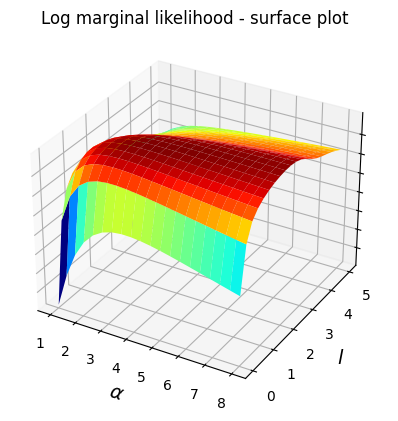

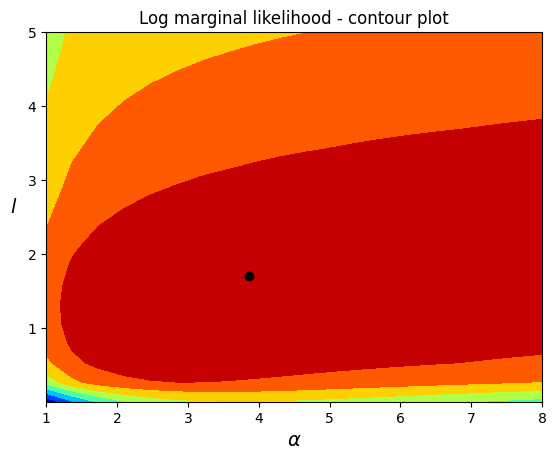

In [23]:
# create values over which the log marginal likelihood will be plotted and form a grid
alphas = np.linspace(1, 8, 20)
ls = np.linspace(0.01, 5, 20)
Alphas, Ls = np.meshgrid(alphas, ls)
# calculate log marginal likelihood for each pair of possible values and store in list
lmls = []
for i in alphas:
    for j in ls:
        lml = log_marginal_likelihood_noise(X_train_4, y_train_4, RBF_cov, [i,j], std_dev, y_train_4_mean)
        lmls.append(lml)
# convert to array and reshape to match grid        
lmls = np.array(lmls).reshape(20, 20)

# surface plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(Alphas, Ls, lmls.T, cmap='jet')
ax.set_zticklabels([])
ax.set_xlabel(r"$\alpha$", fontsize=14)
ax.set_ylabel(r"$l$", fontsize=14)
ax.set_zlabel('Log marginal likelihood')
ax.set_title("Log marginal likelihood - surface plot")
plt.show()

# contour plot
fig = plt.figure()
ax = fig.add_subplot()
ax.contourf(alphas, ls, lmls.T, cmap="jet")
ax.set_xlabel(r"$\alpha$", fontsize=14)
ax.set_ylabel(r"$l$", fontsize=14, rotation=0, labelpad=10)
ax.scatter(res['x'][0], res['x'][1], c='k')
ax.set_title("Log marginal likelihood - contour plot")
plt.show()

From the plots it isn't obvious where the maximum of the log marginal likelihood occurs, but the parameter values we found (indicated by the black dot) correspond to a location in the red region, where the values are largest.

Once we have identified the most probable covariance function parameters, we can make use of them to compute the GP posterior as given in equations (12) - (14).

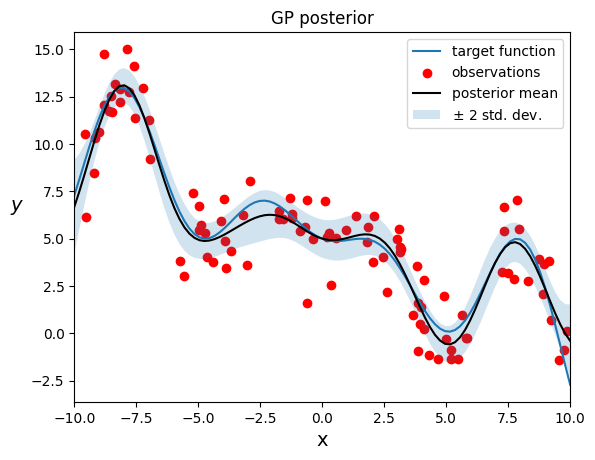

In [24]:
def GP_posterior_noise(X_train, y_train, X_test, kernel_function, std_dev, params, y_train_mean=0):
    
    """
    Computes the GP posterior predictive distribution in the case of noisy data.
    """
    
    K_train_train_y = kernel_function(X_train, X_train, params) + std_dev**2*np.eye(len(X_train))
    K_train_test = kernel_function(X_train, X_test, params)
    K_test_train = kernel_function(X_test, X_train, params)
    K_test_test = kernel_function(X_test, X_test, params)
    K_train_train_y_inv = inv(K_train_train_y)
    # equation (13)
    mean = np.dot(K_test_train, np.dot(K_train_train_y_inv, y_train-y_train_mean))
    # equation (14)
    cov = K_test_test - np.dot(K_test_train, np.dot(K_train_train_y_inv, K_train_test))
    
    return mean, cov 


def plot_GP_posterior_noise(mean, cov, xs, X_train, y_train, X_test):
    
    """
    Plots the GP posterior predicitve distribution in the case of noisy data.
    """
    
    variances = np.diag(cov).copy()
    variances[variances<0]=0
    std_devs = np.sqrt(variances)

    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(xs, function(xs), label="target function")
    ax.scatter(X_train, y_train, c="r", label="observations")
    ax.plot(X_test, mean, c='k', label="posterior mean")
    ax.fill_between(X_test, mean-2*std_devs, mean+2*std_devs, alpha=0.2, label=r"$\pm$ 2 std. dev.")
    ax.set_xlim(-10,10)
    ax.set_xlabel("x", fontsize=14)
    ax.set_ylabel(r"$y$", fontsize=14, rotation=0, labelpad=10)
    ax.set_title("GP posterior")
    plt.legend()
    plt.show()

# compute the predictive mean and covariance, and plot
mean4, cov4 = GP_posterior_noise(X_train_4, y_train_4, X_test, RBF_cov, 1.5, [res['x'][0], res['x'][1]], y_train_4_mean)
plot_GP_posterior_noise(mean4+y_train_4_mean, cov4, xs, X_train_4, y_train_4, X_test)

The model is a decent fit but struggles in some regions. If we wanted to quantify the quality of the model fit to the test data we could compute the mean squared error between the predictions and the true values, or its standardised counterpart.